<a href="https://colab.research.google.com/github/jasonnoy/COMP5329NEW/blob/best_model/5329assn2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# mount google drive to colabif not mounted before
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# import necessary library
import cv2
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

from torch import nn
from torch.utils.data import random_split
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import models
from torchvision import datasets
from torchvision import transforms

from sklearn.metrics import f1_score
from PIL import Image

DEBUG = False

In [3]:
# download data from kaggle server with token file
# must update before use in Colab!
!pip install --upgrade --force-reinstall --no-deps kaggle

# following method of download dataset is from kaggle official forum : https://www.kaggle.com/general/74235
from google.colab import files
print("Please upload your kaggle.jasn token file, to allow direct file download from kaggle to Colab")
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c '2021s1comp5329assignment2'
! unzip -q 2021s1comp5329assignment2.zip
! rm 2021s1comp5329assignment2.zip

data_root_dir = "/content/COMP5329S1A2Dataset/data/"
print("DONE! image files in : ",data_root_dir)

     |████████████████████████████████| 61kB 6.4MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-cp37-none-any.whl size=73053 sha256=58971251562341ed75e5a74bd39c6dafe841928330b8db70708a9b62ea7a3eee
  Stored in directory: /root/.cache/pip/wheels/a1/6a/26/d30b7499ff85a4a4593377a87ecf55f7d08af42f0de9b60303
Successfully built kaggle
  Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12
Please upload your kaggle.jasn token file, to allow direct file download from kaggle to Colab


Saving kaggle.json to kaggle.json
 99% 1.30G/1.31G [00:16<00:00, 69.8MB/s]
100% 1.31G/1.31G [00:16<00:00, 83.5MB/s]
DONE! image files in :  /content/COMP5329S1A2Dataset/data/


In [4]:
print("Please upload fixed train.csv and test.csv")
from google.colab import files
files.upload()
train_csv=pd.read_csv("train.csv")
label_column=train_csv['Labels']
img_column=train_csv['ImageID']
print(label_column)

test_csv=pd.read_csv("test.csv")
test_column=test_csv['ImageID']
print(test_column)

Please upload fixed train.csv and test.csv


Saving test.csv to test.csv
Saving train.csv to train.csv
0             1
1          1 19
2             1
3        8 3 13
4         8 3 7
          ...  
29995     8 1 2
29996         1
29997         1
29998         1
29999         1
Name: Labels, Length: 30000, dtype: object
0       30000.jpg
1       30001.jpg
2       30002.jpg
3       30003.jpg
4       30004.jpg
          ...    
9995    39995.jpg
9996    39996.jpg
9997    39997.jpg
9998    39998.jpg
9999    39999.jpg
Name: ImageID, Length: 10000, dtype: object


In [5]:
# create colums for each class
col_list=np.arange(20)
print(col_list)

# create zeros in np with number of sample from train.csv
labels=pd.DataFrame(np.zeros((len(train_csv),20), dtype=np.int), columns=col_list)
print("zeros shape :",labels.shape)

# change lables matrix value for all samples with split
index=0
for row in label_column:
    label_list=list(map(int, row.split(" ")))
    for i in label_list:
        labels.iloc[index,i] = 1
    index+=1
print(labels)

# combine image file name and label matrix
# and store this dataframe to file
processed_train_set = pd.concat([img_column, labels], axis=1)
print(processed_train_set)
processed_train_set.to_csv("processed_train.csv",index=False)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
zeros shape : (30000, 20)
       0   1   2   3   4   5   6   7   8   ...  11  12  13  14  15  16  17  18  19
0       0   1   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   0   0
1       0   1   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   0   1
2       0   1   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   0   0
3       0   0   0   1   0   0   0   0   1  ...   0   0   1   0   0   0   0   0   0
4       0   0   0   1   0   0   0   1   1  ...   0   0   0   0   0   0   0   0   0
...    ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ..  ..  ..  ..  ..  ..  ..  ..  ..
29995   0   1   1   0   0   0   0   0   1  ...   0   0   0   0   0   0   0   0   0
29996   0   1   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   0   0
29997   0   1   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   0   0
29998   0   1   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   0   0

  0	  1	  2	  3	  4	  5	  6	  7	  8	  9	 10	 11	 12	 13	 14	 15	 16	 17	 18	 19	
0.000	0.490	0.025	0.094	0.027	0.024	0.030	0.026	0.047	0.022	0.032	0.013	0.000	0.013	0.005	0.042	0.024	0.031	0.033	0.022	

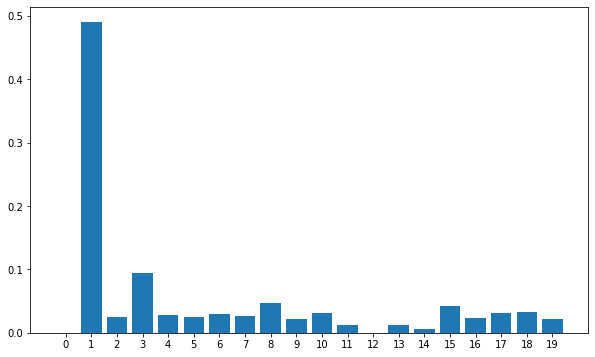

	 row 	 col 	 RGB means 	 RGB stds
[2.40547633e+02 2.89959400e+02 4.21987559e-01 4.23397052e-01
 4.25649481e-01 1.89648016e-01 1.91516552e-01 1.92970209e-01]


In [6]:
# class distribution
class_sum = labels.sum(axis=0)
class_percentage = class_sum/class_sum.sum(axis=0)
for it in col_list:
    print("%3d" %it,end='\t')
print()
for it in col_list:
    print("%.3f" %class_percentage[it],end='\t')

# plot class distribution
fig = plt.figure(figsize =(10, 6))
plt.bar(col_list, class_percentage)
plt.xticks(col_list, col_list)
plt.show()

# image dataset statistics
image_infos = []
tran_stat = transforms.Compose([transforms.ToTensor()])
for it in processed_train_set.ImageID:
    image = np.array(cv2.cvtColor(cv2.imread(data_root_dir+it), cv2.COLOR_BGR2RGB))
    curr_infos = []
    # image N rows and N cols
    curr_infos.append(image.shape[0])
    curr_infos.append(image.shape[1])
    image = tran_stat(image)
    # image RGB value means
    curr_infos.append(image[:,:,0].mean())
    curr_infos.append(image[:,:,1].mean())
    curr_infos.append(image[:,:,2].mean())
    # image RGB value stds
    curr_infos.append(np.sqrt(image[:,:,0].var()+1e-5))
    curr_infos.append(np.sqrt(image[:,:,1].var()+1e-5))
    curr_infos.append(np.sqrt(image[:,:,2].var()+1e-5))
    image_infos.append(curr_infos)

image_infos = np.array(image_infos)
print("\t row \t col \t RGB means \t RGB stds")
image_infos = image_infos.mean(axis=0)
print(image_infos)

In [7]:
class ImageDataset(Dataset):
    def __init__(self, image_infos, data_root_dir=data_root_dir, csv_name="processed_train.csv"):
        self.image_infos = image_infos
        print(self.image_infos)
        self.data_root_dir = data_root_dir
        self.csv_file_label = pd.read_csv(csv_name)
        self.transforms = transforms.Compose([transforms.Resize((int(self.image_infos[0]),int(self.image_infos[1]))) , 
                                            transforms.ToTensor(),
                                            transforms.Normalize([self.image_infos[2], self.image_infos[3], self.image_infos[4]], 
                                                                 [self.image_infos[5], self.image_infos[6], self.image_infos[7]])])
        #self.transforms = transforms.Compose([transforms.Resize((244,244)) , 
        #                       transforms.ToTensor(),
        #                       transforms.Normalize([0.4, 0.4, 0.4], [0.2, 0.2, 0.2])
        #                       ])
    def __len__(self):
        return len(self.csv_file_label)
    
    def __getitem__(self, index):
        #image = cv2.cvtColor(cv2.imread(self.data_root_dir + self.csv_file_label.iloc[index].ImageID), cv2.COLOR_BGR2RGB)
        image = Image.open(self.data_root_dir + self.csv_file_label.iloc[index].ImageID).convert("RGB")
        label = torch.tensor(self.csv_file_label.iloc[index][1:].tolist(), dtype=torch.float32)
        
        return self.transforms(image), label

class ImageDataloader():
    def __init__(self, image_infos, data_root_dir):
        train_percentage = 0.85
        image_dataset = ImageDataset(image_infos, data_root_dir, "processed_train.csv")
        dataset_len = len(image_dataset)
        self.train_set, self.valid_set = random_split(image_dataset, [int(dataset_len*train_percentage), (dataset_len-int(dataset_len*train_percentage))])

    def make_loader(self, batch_size):
        return DataLoader(self.train_set, shuffle=True, batch_size=batch_size), DataLoader(self.valid_set, shuffle=True, batch_size=batch_size)




In [8]:
class TestDataset(Dataset):
    def __init__(self, image_infos, data_root_dir=data_root_dir, csv_name="test.csv"):
        self.image_infos = image_infos
        print(self.image_infos)
        self.data_root_dir = data_root_dir
        self.csv_file_label = pd.read_csv(csv_name)
        self.transforms = transforms.Compose([transforms.Resize((int(self.image_infos[0]),int(self.image_infos[1]))) , 
                                            transforms.ToTensor(),
                                            transforms.Normalize([self.image_infos[2], self.image_infos[3], self.image_infos[4]], 
                                                                 [self.image_infos[5], self.image_infos[6], self.image_infos[7]])])

    def __len__(self):
        return len(self.csv_file_label)
    
    def __getitem__(self, index):
        #image = cv2.cvtColor(cv2.imread(self.data_root_dir + self.csv_file_label.iloc[index].ImageID), cv2.COLOR_BGR2RGB)
        image = Image.open(self.data_root_dir + self.csv_file_label.iloc[index].ImageID).convert("RGB")
        image_ID = self.csv_file_label.iloc[index].ImageID
        
        return self.transforms(image), image_ID

class TestDataloader():
    def __init__(self, image_infos, data_root_dir):
        self.test_set = TestDataset(image_infos, data_root_dir, "test.csv")

    def make_loader(self, batch_size):
        return DataLoader(self.test_set, shuffle=False, batch_size=batch_size)

In [9]:
import torch.nn as nn
class AsymmetricLoss(nn.Module):
    def __init__(self, gamma_neg=4, gamma_pos=1, clip=0.05, eps=1e-8, disable_torch_grad_focal_loss=True):
        super(AsymmetricLoss, self).__init__()

        self.gamma_neg = gamma_neg
        self.gamma_pos = gamma_pos
        self.clip = clip
        self.disable_torch_grad_focal_loss = disable_torch_grad_focal_loss
        self.eps = eps

    def forward(self, x, y):
        """"
        Parameters
        ----------
        x: input logits
        y: targets (multi-label binarized vector)
        """

        # Calculating Probabilities
        x_sigmoid = torch.sigmoid(x)
        xs_pos = x_sigmoid
        xs_neg = 1 - x_sigmoid

        # Asymmetric Clipping
        if self.clip is not None and self.clip > 0:
            xs_neg = (xs_neg + self.clip).clamp(max=1)

        # Basic CE calculation
        los_pos = y * torch.log(xs_pos.clamp(min=self.eps))
        los_neg = (1 - y) * torch.log(xs_neg.clamp(min=self.eps))
        loss = los_pos + los_neg

        # Asymmetric Focusing
        if self.gamma_neg > 0 or self.gamma_pos > 0:
            if self.disable_torch_grad_focal_loss:
                torch.set_grad_enabled(False)
            pt0 = xs_pos * y
            pt1 = xs_neg * (1 - y)  # pt = p if t > 0 else 1-p
            pt = pt0 + pt1
            one_sided_gamma = self.gamma_pos * y + self.gamma_neg * (1 - y)
            one_sided_w = torch.pow(1 - pt, one_sided_gamma)
            if self.disable_torch_grad_focal_loss:
                torch.set_grad_enabled(True)
            loss *= one_sided_w

        return -loss.sum()

In [16]:
class resnet_50:
    def __init__(self, N_classes=20, dropout_p=0.5, N_fc_layers=3):
        """
        :type dropout_p: float
        :param: dropout_p: the chance of nodes stay in the network
        """
        #check device, if GPU avaliable for torch
        self.device = torch.device("cpu")
        if torch.cuda.is_available():
            self.device = torch.device("cuda")

        #self.model = models.resnet50(pretrained=True)
        self.model = models.resnet50(pretrained=True)
        self.N_classes = N_classes
        # decide is need dropout, base on dropout_p value
        # if dropout_p == 1, all node preserved, so no dropout
        self.dropout_p = dropout_p
        self.dropout = False
        if self.dropout_p != 1.0:
            self.dropout = True

        for param in self.model.parameters():
            param.requires_grad = False

        # connect Resnet50 to N_classes output fc
        self.activ_func = nn.ReLU
        N_fc_in = self.model.fc.in_features
        self.N_fc_layers = N_fc_layers
        fc_layers = []

        n_reduce = 4

        if self.dropout:
            for N_it in range(self.N_fc_layers):
                fc_layers.append(nn.Linear(N_fc_in//(n_reduce**N_it), N_fc_in//(n_reduce**(N_it+1))))
                fc_layers.append(nn.ReLU())
                fc_layers.append(nn.BatchNorm1d(N_fc_in//(n_reduce**(N_it+1))))
                # nn.dropout use probability of dropout as input
                fc_layers.append(nn.Dropout(1-self.dropout_p))
        else:
            for N_it in range(self.N_fc_layers):
                fc_layers.append(nn.Linear(N_fc_in//(n_reduce**N_it), N_fc_in//(n_reduce**(N_it+1))))
                fc_layers.append(nn.ReLU())
                fc_layers.append(nn.BatchNorm1d(N_fc_in//(n_reduce**(N_it+1))))
        
        # last layer to connect to N_classes
        fc_layers.append(nn.Linear(N_fc_in//(n_reduce**(self.N_fc_layers)), self.N_classes))
        # add custom fc layers to Resnet
        self.model.fc = nn.Sequential(*fc_layers)

        if DEBUG:
            print(self.model)

        # change device
        self.model = self.model.to(self.device)

        #define the min threshold for prediction
        self.predict_threshold = 0.5

    def accuracy_calculate(self, y_true, outputs_torch, curr_batch_size):
        y_true = y_true.to(torch.int).numpy()
        y_pred = (torch.sigmoid(outputs_torch).data > self.predict_threshold).cpu().detach().to(torch.int).numpy()
        return f1_score(y_true, y_pred, average='samples')*curr_batch_size

    def train(self, train_dataloader, valid_dataloader, N_epochs=10, learning_rate=0.01, optimizer="adam", scheduler="steplr"):
        self.learning_rate = learning_rate
        self.len_train = len(train_dataloader.dataset)
        self.len_valid = len(valid_dataloader.dataset)

        self.optimizer = None
        # add training optimizers
        if optimizer == "adamw":
            print("optimizer : AdamW")
            self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=self.learning_rate)
        elif optimizer == "sparseadam":
            print("optimizer : SparseAdam")
            self.optimizer = torch.optim.SparseAdam(self.model.parameters(), lr=self.learning_rate)
        else:
            print("optimizer : Adam")
            # default as Adam
            self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)

        # add training schedulers
        self.scheduler = None
        if scheduler == "reducelr":
            print("scheduler : ReduceLROnPlateau")
            self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, 'min')
        elif scheduler == "cosinelr":
            print("scheduler : CosineAnnealingLR")
            self.scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=5, eta_min=0.005)
        else:
            print("scheduler : StepLR")
            # default as steplr
            self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=5, gamma=0.1)

        # add training optimizaers
        self.criterion = nn.BCEWithLogitsLoss()
        #self.criterion = AsymmetricLoss()

        # recode evaluation matries for each epoch
        #============================train==============================
        for epoch_it in range(N_epochs):
            #epoch loop
            print("epoch:{}/{}".format((epoch_it+1), N_epochs),end=' ')
            train_accuracy = 0.0 
            train_loss = 0.0
            self.model.train()

            for images, labels in train_dataloader:
                torch.set_grad_enabled(True)
                # batch loop
                images = images.to(self.device)
                labels_processed = labels.to(self.device)
                curr_batch_size = images.size(0)
                
                # get output and calculate accuracy
                outputs = self.model(images)
                train_accuracy += self.accuracy_calculate(labels, outputs, curr_batch_size)

                # loss & backpropergate
                loss = self.criterion(outputs, labels_processed)
                loss.backward()
                train_loss += curr_batch_size*loss.item()

                # update parameters by grads & reset grads
                self.optimizer.step()
                self.optimizer.zero_grad()
            
            # train print out
            print("train loss:%.4f"%(train_loss/self.len_train),
                  "accuracy:%.4f"%(train_accuracy/self.len_train),end=' ')

            #============================valid==============================
            valid_accuracy = 0.0
            valid_loss = 0.0
            self.model.eval()
       
            for images, labels in valid_dataloader:
                torch.set_grad_enabled(False)
                # batch loop
                images = images.to(self.device)
                labels_processed = labels.to(self.device)
                curr_batch_size = images.size(0)
                
                # get output and calculate accuracy
                outputs = self.model(images)
                valid_accuracy += self.accuracy_calculate(labels, outputs, curr_batch_size)

                # loss & backpropergate
                loss = self.criterion(outputs, labels_processed)
                valid_loss += curr_batch_size*loss.item()

            # valid print out
            print("\tvalid loss:%.4f"%(valid_loss/self.len_valid),
                  "accuracy:%.4f"%(valid_accuracy/self.len_valid))
            
            self.scheduler.step()

    def test_pred(self, outputs_torch, curr_batch_size):
        y_pred = (torch.sigmoid(outputs_torch).data > self.predict_threshold).cpu().detach().to(torch.int).numpy()
        return y_pred

    def predict(self, test_dataloader, output_file_name='Predicted_labels.txt'):
    #============================test==============================
        self.model.eval()
        output_file = open(output_file_name,"w+")

        for images, image_ID in test_dataloader:
            torch.set_grad_enabled(False)
            # batch loop
            images = images.to(self.device)
            curr_batch_size = images.size(0)
            
            # get output and calculate accuracy
            outputs = self.model(images)

            y_preds = self.test_pred(outputs, curr_batch_size)
            output_file.write("ImageID,Labels")

            for it in range(len(y_preds)):
                output_file.write("%s,"%image_ID[it])

                pred_label = np.atleast_1d(np.squeeze(np.argwhere(y_preds[it]==1)))
                for label_it in pred_label:
                    output_file.write(" %d"%label_it)
                output_file.write('\n')

        output_file.close()        

    def save(self, name):
        torch.save(self.model, "my_model_"+name+".pth")

    def load(self, file):
        self.model = torch.load(file)

In [ ]:
#DEBUG = False

#for dropout_p in [0.8]:
#    print("\n===============dropout_p:",dropout_p)
#    for optimizer in ["adam", "adamw"]:
#        res50 = resnet_50(N_classes=20, dropout_p=dropout_p, N_fc_layers=3)

#        dataset_loader = ImageDataloader(image_infos, data_root_dir)
#        (train_set, valid_set) = dataset_loader.make_loader(batch_size = 128)
#        res50.train(train_dataloader=train_set, valid_dataloader=valid_set, N_epochs=20, learning_rate=0.001, optimizer=optimizer, scheduler="cosinelr")

In [17]:
DEBUG = False

res50 = resnet_50(N_classes=20, dropout_p=0.8, N_fc_layers=1)

dataset_loader = ImageDataloader(image_infos, data_root_dir)
(train_set, valid_set) = dataset_loader.make_loader(batch_size = 128)
res50.train(train_dataloader=train_set, valid_dataloader=valid_set, N_epochs=20, learning_rate=0.001, optimizer="adam", scheduler="cosinelr")

test_set = TestDataloader(image_infos, data_root_dir).make_loader(batch_size = 128)
res50.predict(test_set)
files.download('Predicted_labels.txt')

[2.40547633e+02 2.89959400e+02 4.21987559e-01 4.23397052e-01
 4.25649481e-01 1.89648016e-01 1.91516552e-01 1.92970209e-01]
optimizer : Adam
scheduler : CosineAnnealingLR
epoch:1/20 train loss:0.2524 accuracy:0.6672 	valid loss:0.0952 accuracy:0.7873
epoch:2/20 train loss:0.0919 accuracy:0.7921 	valid loss:0.0941 accuracy:0.7860
epoch:3/20 train loss:0.0896 accuracy:0.7959 	valid loss:0.0871 accuracy:0.8007
epoch:4/20 train loss:0.0888 accuracy:0.7966 	valid loss:0.0914 accuracy:0.7998
epoch:5/20 train loss:0.0878 accuracy:0.8002 	valid loss:0.0874 accuracy:0.8023
epoch:6/20 train loss:0.0865 accuracy:0.8032 	valid loss:0.0878 accuracy:0.7828
epoch:7/20 train loss:0.0840 accuracy:0.8092 	valid loss:0.0854 accuracy:0.8036
epoch:8/20 train loss:0.0819 accuracy:0.8138 	valid loss:0.0837 accuracy:0.8148
epoch:9/20 train loss:0.0794 accuracy:0.8199 	valid loss:0.0833 accuracy:0.8167
epoch:10/20 train loss:0.0767 accuracy:0.8265 	valid loss:0.0816 accuracy:0.8189
epoch:11/20 train loss:0.0747

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [18]:
res50.save("save1")
#files.download('my_model_save1.pth')

In [ ]:
#res50 = resnet_50(N_classes=20, dropout_p=0.8, N_fc_layers=2)
#test_set = TestDataloader(image_infos, data_root_dir).make_loader(batch_size = 128)
#res50.predict(test_set)
def load_model(file):
    return pytorch.load(file)